In [1]:
%matplotlib inline
import os
import glob
import pickle
import curlovision as cvis
import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.collections import PatchCollection
import numpy as np
import math

In [2]:
# Loop over and load all processed MatchResults
results = glob.glob('MatchResults/*.pkl')
match_results = []
for filename in results:
    print('Processing MatchResult: {}'.format(filename))
    with open(filename, 'rb') as f:
        match_results.append(pickle.load(f))

Processing MatchResult: MatchResults/PyeongChang.Olympics.2018.curling.men's.bronze.medal.match.Switzerland.v.Canada.1080p.NBC.WEB-DL-FINFUNGUS.mp4.pkl
Processing MatchResult: MatchResults/PyeongChang.Olympics.2018.curling.men's.gold.medal.match.Sweden.v.USA.1080p.NBC.WEB-DL-FINFUNGUS.mp4.pkl
Processing MatchResult: MatchResults/PyeongChang.Olympics.2018.curling.men's.round-robin.Canada.v.Sweden.1080p.NBC.WEB-DL-FINFUNGUS.mp4.pkl
Processing MatchResult: MatchResults/PyeongChang.Olympics.2018.curling.men's.round-robin.Denmark.v.Sweden.1080p.NBC.WEB-DL-FINFUNGUS.mp4.pkl
Processing MatchResult: MatchResults/PyeongChang.Olympics.2018.curling.men's.round-robin.Great.Britain.v.Denmark.1080p.NBC.WEB-DL-FINFUNGUS.mp4.pkl
Processing MatchResult: MatchResults/PyeongChang.Olympics.2018.curling.men's.round-robin.Japan.v.Canada.1080p.NBC.WEB-DL-FINFUNGUS.mp4.pkl
Processing MatchResult: MatchResults/PyeongChang.Olympics.2018.curling.men's.round-robin.Sweden.v.Norway.1080p.NBC.WEB-DL-FINFUNGUS.mp4.pk

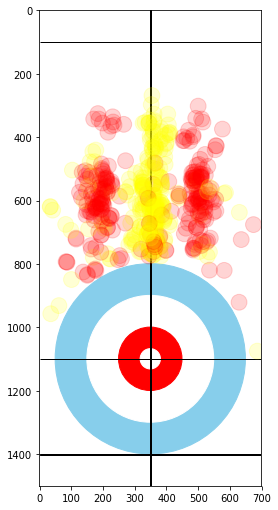

In [3]:
# Start with the background
h=1500
patches,ft2px,xc,yc = cvis.draw_house(height=h)

# Loop over stones and do some analysis of the first 4 stones
results = []
nmatches = 0
nends = 0
for mr in match_results[:]:
    nmatches += 1
    #print(mr.name)
    prev_red_score = 0  # Each game starts at 0
    prev_yel_score = 0
    for er in mr.end_results[:]:
        nends += 1
        red_score_gain = er.red_score - prev_red_score
        yel_score_gain = er.yel_score - prev_yel_score
        hammer_color = 'red' if er.red_hammer else 'yellow'
        hammer_score_gain = red_score_gain if er.red_hammer else yel_score_gain
        nonham_score_gain = yel_score_gain if er.red_hammer else red_score_gain
        free_guards_total  = 0
        free_guards_hammer = 0
        free_guards_nonham = 0
        for layout,stones_left in zip(er.stone_layouts,er.stones_left):
            stones_thrown = (16 - stones_left[0] - stones_left[1])
            for stone in layout.stones:
                if stones_thrown > 4:
                    continue
                hammer_team = True if stone.color==hammer_color else False # Rock thrown by team with hammer?
                x = stone.x
                y = stone.y
                r = math.sqrt(x**2 + y**2) - layout.stone_radius  # distance of closest edge of stone to center
                if x<-7 or x>7 or y<-8 or y>20: continue  # Filter out-of-bounds stones
                # Is the stone in the free guard zone?
                if y>0 and y<20 and r>6:
                    #print('Free Guard found',x,y,r)
                    free_guards_total += 1
                    if hammer_team: free_guards_hammer += 1
                    else:           free_guards_nonham += 1
                else: continue
                c=[1,0,0] if hammer_team else [1,1,0]  # Red if hammer or Yellow if nonhammer for this end
                alpha = 0.17
                #alpha = 0.12 if n<=4 else 0.03  # Make lead stones heftier
                patches.append(Circle((xc+x*ft2px, yc-y*ft2px), 0.5*ft2px ,color=c,alpha=alpha))

        # Record a list of number of guards and resulting score:
        results.append((free_guards_hammer,free_guards_nonham,hammer_score_gain,nonham_score_gain))
        #print(free_guards_hammer,free_guards_nonham,hammer_score_gain,nonham_score_gain)
        prev_red_score = er.red_score
        prev_yel_score = er.yel_score

# Display everything
fig = plt.figure(figsize=(h/80.,int(h*14./30.)/80.))
img = np.ones((h,int(h*14./30.),3),dtype=float)
plt.imshow(img)
for patch in patches:
    fig.gca().add_patch(patch)
plt.show()

In [4]:
# There's one odd end result with a score gain of ~28 (score of 33 I think - it's an error, let's filter it out)
results = np.array(results)
print(len(results))
results = results[results[:,3]<=8]
results = results[results[:,3]>=0]
results[:,0] = np.clip(results[:,0],0,3)
results[:,1] = np.clip(results[:,1],0,3)
print(len(results))

213
211


In [5]:
# Simplify the results to make it easier to interpret:
for i,result in enumerate(results):
    #print(i,result)
    if result[0]==1 or result[0]==2: result[0]=1
    if result[0]>=3: result[0]=2
    if result[1]==1 or result[1]==2: result[1]=1
    if result[1]>=3: result[1]=2
    

In [6]:
# Print some basic stats:
print("Total matches analyzed:",nmatches)
print("Total ends analyzed:",nends)
print("Total free guards thrown by hammer team:",np.sum(results[:,0]))
print("Total free guards thrown by nonham team:",np.sum(results[:,1]))
print("Total points from hammer teams:",np.sum(results[:,2]))
print("Total points from nonham teams:",np.sum(results[:,3]))

print("Total number of ends with no free guards thrown by hammer team:",np.sum(len(results[results[:,0]==0])))
print("Total number of ends with no free guards thrown by nonham team:",np.sum(len(results[results[:,1]==0])))


Total matches analyzed: 24
Total ends analyzed: 213
Total free guards thrown by hammer team: 162
Total free guards thrown by nonham team: 149
Total points from hammer teams: 225
Total points from nonham teams: 45
Total number of ends with no free guards thrown by hammer team: 93
Total number of ends with no free guards thrown by nonham team: 112


<function matplotlib.pyplot.show(*args, **kw)>

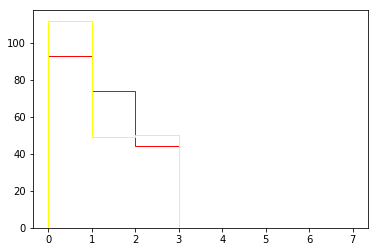

In [8]:
# Just plot the raw score distributions for the hammer(red) and non-hammer teams:
plt.figure()
bins = np.linspace(0,7,8)
#plt.yscale('log')
plt.hist(results[:,0],histtype='step',bins=bins,color='red')
plt.hist(results[:,1],histtype='step',bins=bins,color='yellow')
plt.show

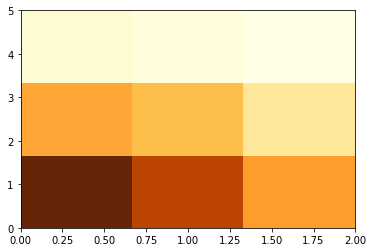

In [9]:
# Hammer team score vs number of free guards that they throw:
plt.figure()
plt.hist2d(results[:,0],results[:,2],bins=[3,np.max(results[:,3])],cmap='YlOrBr')
plt.show()

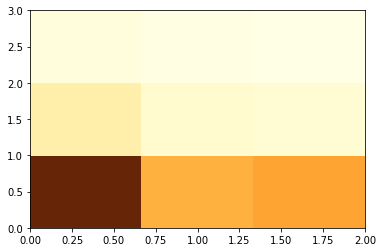

In [10]:
# Non-hammer team score vs number of free guards that they throw:
plt.figure()
plt.hist2d(results[:,1],results[:,3],bins=[3,np.max(results[:,3])],cmap='YlOrBr')
plt.show()

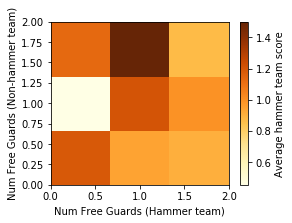

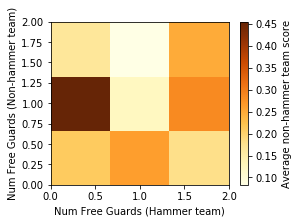

In [11]:
hcounts,xedges,yedges = np.histogram2d(results[:,0],results[:,1],bins=[3,3])
h1,xedges,yedges      = np.histogram2d(results[:,0],results[:,1],weights=results[:,2],bins=[3,3])
h2,xedges,yedges      = np.histogram2d(results[:,0],results[:,1],weights=results[:,3],bins=[3,3])

plt.figure(figsize=(4,3))
plt.xlabel('Num Free Guards (Hammer team)')
plt.ylabel('Num Free Guards (Non-hammer team)')#np.clip(ratio,0.5,1.5,out=ratio)
X,Y = np.meshgrid(xedges, yedges)
ratio = np.divide(h1,hcounts)
#ratio[np.isnan(ratio)] = 1.0
#pc = plt.gca().pcolormesh(X, Y, h1.T, cmap='YlOrBr')
pc = plt.gca().pcolormesh(X, Y, ratio.T, cmap='YlOrBr')
plt.colorbar(pc).set_label(r'Average hammer team score')
plt.show()


plt.figure(figsize=(4,3))
plt.xlabel('Num Free Guards (Hammer team)')
plt.ylabel('Num Free Guards (Non-hammer team)')#np.clip(ratio,0.5,1.5,out=ratio)
X,Y = np.meshgrid(xedges, yedges)
ratio = np.divide(h2,hcounts)
#ratio[np.isnan(ratio)] = 1.0
#pc = plt.gca().pcolormesh(X, Y, h1.T, cmap='YlOrBr')
pc = plt.gca().pcolormesh(X, Y, ratio.T, cmap='YlOrBr')
plt.colorbar(pc).set_label(r'Average non-hammer team score')
plt.show()

In [13]:
avg_score_hammer = np.average(results[:,2])
avg_score_nonham = np.average(results[:,3])

print( 'Average score of the hammer team: {:1f}'.format(avg_score_hammer) )
print( 'Average score of the nonham team: {:1f}'.format(avg_score_nonham) )

# Filter out blank ends where the hammer team decides to keep the hammer:
avg_score_hammer_noblanks = np.average(results[(results[:,2]>0) | (results[:,3]>0)][:,2])
print( '-->hammer but with no blank ends: {:1f}'.format(avg_score_hammer_noblanks) )


Average score of the hammer team: 1.066351
Average score of the nonham team: 0.213270
-->hammer but with no blank ends: 1.339286


In [14]:
# E.g. List of scores of the hammer team when 2 free guards were in play. 
print( len(results[results[:,0]==2][:,2]) )

44


In [20]:
num_guards = np.array([0,1,2],dtype=int)
avg_hammer_scores = np.empty(len(num_guards))
avg_nonham_scores = np.empty(len(num_guards))
for num_guard in num_guards:
    # Including blank ends:
    #avg_hammer_scores[num_guard] = np.average(results[(results[:,0]==num_guard)][:,2])
    # Filter out blank ends:
    avg_hammer_scores[num_guard] = np.average(results[(results[:,0]==num_guard) & ((results[:,2]>0) | (results[:,3]>0))][:,2])
    avg_nonham_scores[num_guard] = np.average(results[results[:,1]==num_guard][:,3])

print('Number of free guards   : {:1d},   \t{:1d},   \t{:1d}'.format(0,1,2))
print('Avg score of hammer team: {:0.2f},\t{:0.2f},\t{:0.2f}'.format(avg_hammer_scores[0],avg_hammer_scores[1],avg_hammer_scores[2]))
print('Avg score of nonham team: {:0.2f},\t{:0.2f},\t{:0.2f}'.format(avg_nonham_scores[0],avg_nonham_scores[1],avg_nonham_scores[2]))


Number of free guards   : 0,   	1,   	2
Avg score of hammer team: 1.40,	1.38,	1.14
Avg score of nonham team: 0.22,	0.24,	0.16


In [23]:
num_guards = np.array([0,1,2],dtype=int)
count        = np.empty(len(num_guards),dtype=int)
hammer_blank = np.empty(len(num_guards),dtype=int)
hammer_multi = np.empty(len(num_guards),dtype=int)
nonham_steal = np.empty(len(num_guards),dtype=int)
for num_guard in num_guards:
    sub_results = results[(results[:,0]==num_guard)]  # For hammer team
    #sub_results = results[(results[:,1]==num_guard)]  # For non-hammer team
    count[num_guard] = len(sub_results)
    hammer_blank[num_guard] = len(sub_results[(sub_results[:,2]==0) & (sub_results[:,3]==0)])
    hammer_multi[num_guard] = len(sub_results[sub_results[:,2]>1])
    nonham_steal[num_guard] = len(sub_results[sub_results[:,3]>0])

print('Number of hammer guards : {:1d},   \t{:1d},   \t{:1d}'.format(0,1,2))
print('Number of ends          : {:1d},\t{:1d},\t{:1d}'.format(count[0],count[1],count[2],))
print('Number of blank end     : {:1d},\t{:1d},\t{:1d}'.format(hammer_blank[0],hammer_blank[1],hammer_blank[2]))
print('Number hammer 2+ scores : {:1d},\t{:1d},\t{:1d}'.format(hammer_multi[0],hammer_multi[1],hammer_multi[2]))
print('Number of steals        : {:1d},\t{:1d},\t{:1d}'.format(nonham_steal[0],nonham_steal[1],nonham_steal[2]))


Number of hammer guards : 0,   	1,   	2
Number of ends          : 93,	74,	44
Number of blank end     : 21,	14,	8
Number hammer 2+ scores : 32,	26,	14
Number of steals        : 16,	11,	10


'''
Summary:
We see an average hammer-team score of 1.07 and non-hammer-team score of 0.21 per end.  Hammer teams often keep a
strategic advantage by forcing a blank end, so we'll consider that separately.  Filtering out blank ends gives
an average hammer-team score of 1.34.  Hammer-teams who only use zero or one free guard end up scoring more than
the average, 1.40 and 1.37 respectively.  Only ~20% (43 out of 211 ends analyzed) showed a hammer-team using 
both available free guards, and the average score was significantly reduced 1.34 --> 1.17 in this case.  The
chance for the non-hammer team to steal increases when the hammer team uses both guards (17-->21%), and the chance
to force a blank end descreases by a similar magnitude (21%-->16%).  Hard to say if it's the hammer team being
forced to blank the end or if it is done by choice, but the conclusion is more stones = more chaos. 

The non-hammer team's score and chance to steal showed a similar trend.  The average score of 0.21 improves 
slightly when using zero or one free guard (0.21 and 0.25, repectively) but again decreases when using 
both guards (0.16).  Tracking that, the chance to steal decreases from 18% --> 15% when using two free guards.  

In short, utilizing 0 or 1 stones for a guard is the most common and highest scoring opening play.  But expending
a second stone as an opening guard somewhat decreases scoring potential for the both the hammer and non-hammer teams.

A more in-depth and practical analysis would look at this as decision tree:
 1) Do I have the lead (non-hammer team)?
   (yes) Should I or shouldn't I use my first stone as a free guard?
   (no ) Was the opening stone a free guard
 etc.
 
However, the long-term goal of this project is to build a machine learning model that does this all for us in a more
general manner than just looking at free guards!
'''